# YouTube Transcript Agent with LangChain & OpenAI as LLM

This notebook demonstrates how to use a LangChain agent with OpenAI as the LLM and a custom YouTube transcript tool.

In [1]:
# 1. Install dependencies (uncomment and run if needed)
# !pip install langchain langchain_community youtube-transcript-api

In [2]:
# 2. Imports
import re
import os
from youtube_transcript_api import YouTubeTranscriptApi
from langchain.tools import Tool
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
#Set up the Ollama LLM (using updated langchain_ollama package)
from langchain_ollama import OllamaLLM

from typing import Literal

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as langchain_tool


In [3]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [4]:
def create_llm(model_name: str = "llama3.2:latest") -> OllamaLLM:
    """
    Pure function to create an OllamaLLM instance.
    Args:
        model_name (str): The name of the Ollama model to use.
    Returns:
        OllamaLLM: An instance of the OllamaLLM.
    """
    return OllamaLLM(model=model_name)
#model_ollama = create_llm()

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [5]:
import httpx
from openai import OpenAI
from openai import RateLimitError, AuthenticationError, APIConnectionError, APIError

def diagnose_openai_connection(model):
    """
    Diagnoses possible causes for OpenAI API 429 errors, including quota, IP block, and network issues.
    Returns a dict with diagnostic results.
    """
    diagnostics = {}

    # 1. Check if API key is valid
    try:
        # This will fail fast if the key is invalid
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        client.models.list()
        diagnostics['api_key_valid'] = True
    except AuthenticationError as e:
        diagnostics['api_key_valid'] = False
        diagnostics['error'] = f"AuthenticationError: {e}"
        return diagnostics
    except Exception as e:
        diagnostics['api_key_valid'] = False
        diagnostics['error'] = f"Unexpected error during API key check: {e}"
        return diagnostics

    # 2. Check if IP is blocked (simulate by calling a simple endpoint)
    try:
        with httpx.Client(timeout=10.0) as client:
            response = client.get(
                "https://api.openai.com/v1/models",
                headers={
                    "Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}"
                }
            )
        diagnostics['http_status'] = response.status_code
        if response.status_code == 429:
            diagnostics['ip_blocked_or_rate_limited'] = True
        else:
            diagnostics['ip_blocked_or_rate_limited'] = False
    except Exception as e:
        diagnostics['ip_blocked_or_rate_limited'] = None
        diagnostics['error'] = f"Network error: {e}"
        return diagnostics

    # 3. Try a simple model invocation and catch errors
    try:
        result = model.invoke("Hello, how are you?")
        diagnostics['model_invoke_success'] = True
        diagnostics['result'] = str(result)
    except RateLimitError as e:
        diagnostics['model_invoke_success'] = False
        diagnostics['error'] = f"RateLimitError: {e}"
    except APIConnectionError as e:
        diagnostics['model_invoke_success'] = False
        diagnostics['error'] = f"APIConnectionError: {e}"
    except APIError as e:
        diagnostics['model_invoke_success'] = False
        diagnostics['error'] = f"APIError: {e}"
    except Exception as e:
        diagnostics['model_invoke_success'] = False
        diagnostics['error'] = f"Other error: {e}"

    return diagnostics

def print_diagnostics(diagnostics):
    print("OpenAI API Diagnostics:")
    for k, v in diagnostics.items():
        print(f"  {k}: {v}")


In [6]:
# 4. Diagnose OpenAI connection
#diagnostics = diagnose_openai_connection(model)
#print_diagnostics(diagnostics)

In [7]:
# 3. Pure functional YouTube transcript tool
@langchain_tool
def fetch_youtube_transcript(url: str) -> str:
    """
    Extract transcript with timestamps from a YouTube video URL and format it for LLM consumption.
    Args:
        url (str): YouTube video URL
    Returns:
        str: Formatted transcript with timestamps, each entry on a new line as "[MM:SS] Text"
    """
    import re
    from typing import Any

    def extract_video_id(url: str) -> str:
        video_id_pattern = r'(?:v=|\/)([0-9A-Za-z_-]{11}).*'
        video_id_match = re.search(video_id_pattern, url)
        if not video_id_match:
            raise ValueError("Invalid YouTube URL")
        return video_id_match.group(1)

    def format_entry(entry: Any) -> str:
        # Try attribute access, fallback to dict-style if needed
        start = getattr(entry, 'start', None)
        text = getattr(entry, 'text', None)
        if start is None or text is None:
            # fallback to dict-style (for older API versions)
            start = entry['start']
            text = entry['text']
        return f"[{int(start//60):02d}:{int(start%60):02d}] {text}"

    video_id = extract_video_id(url)
    transcript = YouTubeTranscriptApi().fetch(video_id=video_id, languages=['en', 'ta'])
    formatted_entries = list(map(format_entry, transcript))
    return "\n".join(formatted_entries)

In [8]:
print(type(fetch_youtube_transcript))
print(hasattr(fetch_youtube_transcript, "invoke"))

<class 'langchain_core.tools.structured.StructuredTool'>
True


In [9]:
tools = [fetch_youtube_transcript]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [10]:
# 8. (Optional) Test for the tool
def test_fetch_youtube_transcript():
    url = "https://www.youtube.com/watch?v=ZaY5_ScmiFE"
    transcript = fetch_youtube_transcript.invoke(url)
    assert isinstance(transcript, str)
    assert "[00:" in transcript
    print("Transcript test passed.")

# Uncomment to run the test
test_fetch_youtube_transcript()

Transcript test passed.


In [11]:
def call_llm(state: MessagesState):
    messages = [
        SystemMessage(content="You are a helpful assistant that can run python code."),
    ] + state["messages"]
    return {"messages": [model_with_tools.invoke(messages)]}


def call_tool(state: MessagesState):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["environment", "END"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return "END"


In [12]:
agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm", call_llm)
agent_builder.add_node("environment", call_tool)

agent_builder.add_edge(START, "llm")
# the node to be called next is determined by the function should_continue()
# whose return statement is either "Action" or END and this is used to determine the next node to be called
# if the return statement is "Action", then the node "environment" is called
# if the return statement is END, then the agent is terminated
agent_builder.add_conditional_edges(
    "llm",
    should_continue,
    {
        "Action": "environment",
        "END": END,
    },
)
agent_builder.add_edge("environment", "llm")

agent = agent_builder.compile()

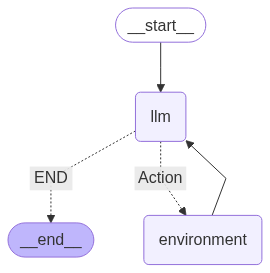

In [13]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [14]:
from typing import Callable, List

def build_transcript_messages(
    url: str, 
    start_time: str = None, 
    end_time: str = None, 
    translation: bool = False
) -> List:
    """
    Builds the messages required for the agent to generate a transcript for a given YouTube URL.
    If translation is True, requests translation into English.
    Args:
        url (str): The YouTube video URL.
        start_time (str, optional): Start time for transcript.
        end_time (str, optional): End time for transcript.
        translation (bool, optional): Whether to translate transcript into English.
    Returns:
        List: A list of SystemMessage and HumanMessage objects.
    """
    base_instruction = (
        f"Generate a transcript for the video given by the user at url:{url}"
        + (
            f" from {start_time} to {end_time}."
            if start_time is not None and end_time is not None
            else "."
        )
    )
    if translation:
        base_instruction += " Translate the transcript into English if it is not already in English."
    return [
        SystemMessage(content="You are a helpful assistant that can run transcribe youtube URL videos."),
        HumanMessage(content=base_instruction),
    ]

In [18]:
# Example usage: Make sure the URL vide has subtitles turned on ... else this will not be able to extract data!
url = "https://www.youtube.com/watch?v=ZaY5_ScmiFE"
#url = 'https://www.youtube.com/watch?v=6zDU9JlJp_0'
#url = 'https://www.youtube.com/watch?v=mgC8jO7aAMM&t=1160s'
messages = build_transcript_messages(url, start_time="00:00", end_time="00:15", translation=True)

In [19]:
messages = agent.invoke({"messages": messages})

In [20]:
for m in messages["messages"]:
    m.pretty_print()

================================ System Message ================================

You are a helpful assistant that can run transcribe youtube URL videos.
================================ Human Message =================================

Generate a transcript for the video given by the user at url:https://www.youtube.com/watch?v=ZaY5_ScmiFE from 00:00 to 00:15. Translate the transcript into English if it is not already in English.
================================== Ai Message ==================================
Tool Calls:
  fetch_youtube_transcript (call_KjsxSE0r6BZaCZNKNDNtDpu0)
 Call ID: call_KjsxSE0r6BZaCZNKNDNtDpu0
  Args:
    url: https://www.youtube.com/watch?v=ZaY5_ScmiFE
================================= Tool Message =================================

[00:00] Hey everyone, I'm Shaw. This is the
[00:02] first video in a larger series on AI
[00:05] agents. Here I'll start by discussing
[00:07] what an AI agent actually is and why we
[00:10] should care about them. Then I'll review
